In [1]:
%load_ext autoreload

# FlexConv demo

In this notebook, we illustrate the construction of a simple FlexNet, proposed in our work [FlexConv: Continuous Kernel Convolutions with Differentiable Kernel Sizes](https://arxiv.org/abs/2110.08059). The code provided here is a simplified version of the main code. For baseline comparisons please refer to the main code.

In particular, we will:
* Show how to instantiate a FlexConv layer, from the `ckconv` package.
* Show how to instantiate a FlexNet network, from the `models` package.
* Show how to regularize a FlexConv/FlexNet against aliasing.

Let's go! First, we import some packages:

In [2]:
%autoreload

# Append .. to path
import os,sys
ckconv_source =  os.path.join(os.getcwd(), '..')
if ckconv_source not in sys.path:
    sys.path.append(ckconv_source)
    
import numpy as np
import torch
from torch.nn.utils import weight_norm
from omegaconf import OmegaConf

import ckconv.nn as cknn
from models import Img_ResNet

from matplotlib import pyplot as plt
from PIL import Image

## FlexConv

The FlexConv module can be used in place of a regular convolutional module in any architecture. The only required argument that is novel w.r.t. to vanilla convolutions is the `horizon` value, which is the largest kernel size the FlexConv can learn. The horizon should be an odd integer, so that the learned kernel is centered on a pixel, instead of on a subpixel. We recommend it to be the image size.

The init signature of FlexConv is quite long, as it takes many arguments. Almost all arguments however are provided a default value, which the user does not need to think about.

```python
"""
Flexible Size Continuous Kernel Convolution.

:param in_channels: Number of channels in the input signal
:param out_channels: Number of channels produced by the convolution
:param horizon: Maximum kernel size. Recommended to be odd and cover the entire conv_image.
:param kernel_type: Identifier for the type of kernel generator to use.
:param kernel_dim_linear: Dimensionality of the input signal, e.g. 2 for images.
:param kernel_no_hidden: Amount of hidden channels to use.
:param kernel_activ_function: Activation function for type=MLP.
:param kernel_norm: Normalization function for type=MLP.
:param kernel_weight_norm: Weight normalization, for type=[MLP, SIREN, nSIREN].
:param kernel_no_layers: Amount of layers to use in kernel generator.
:param kernel_omega_0: Initial value for omega_0, for type=SIREN.
:param kernel_learn_omega_0: Whether to learn omega_0, for type=SIREN.
:param kernel_steerable: Whether to learn steerable kernels, for type=MAGNet.
:param kernel_init_spatial_value: Initial mu for gabor filters, for type=[GaborNet, MAGNet].
:param kernel_bias_init: Bias init strategy, for all types but type=MLP.
:param kernel_input_scale: Scaling factor for linear functions, for type=[GaborNet, MAGNet].
:param kernel_sampling_rate_norm: Kernel scaling factor for sampling rate normalization.
:param conv_use_fft: Whether to use FFT implementation of convolution.
:param conv_bias: Whether to use bias in kernel generator. TODO(rjbruin): move to kernel_config.
:param conv_padding: Padding strategy for convolution.
:param conv_stride: Stride applied in convolution.
:param mask_use: Whether to apply Gaussian mask.
:param mask_type: Type of mask. Recommended to use "gaussian".
:param mask_init_value: Initial value for the size of the kernel.
:param mask_temperature: Temperature of the sigmoid function, for type=sigmoid.
:param mask_dynamic_cropping: Whether to crop away pixels below the threshold.
:param mask_threshold: Threshold for cropping pixels. Recommended to be 15.0.
"""
```

In [3]:
# Override default config values
in_channels = 3
out_channels = 3
horizon = 33

flexconv_example = cknn.FlexConv(
    in_channels,
    out_channels,
    horizon,
)

Let's convolve a random CIFAR-10 image with our randomly initialized FlexConv:

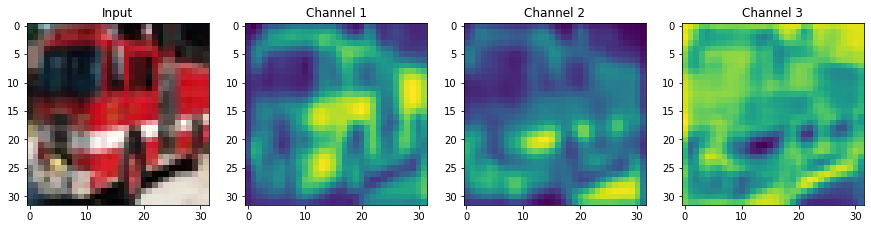

In [4]:
fig, axs = plt.subplots(1, 4, figsize=(15, 5))

x_pyplot = np.asarray(Image.open('truck5.png')) / 255.
axs[0].imshow(x_pyplot)
axs[0].set_title('Input')

x_net = torch.tensor(x_pyplot, dtype=torch.float32).permute(2, 0, 1)
x_net = x_net.reshape(1, 3, x_pyplot.shape[0], x_pyplot.shape[1])
y_net = flexconv_example(x_net)[0]
y_pyplot = y_net.detach().numpy()
axs[1].imshow(y_pyplot[0])
axs[1].set_title('Channel 1')
axs[2].imshow(y_pyplot[1])
axs[2].set_title('Channel 2')
axs[3].imshow(y_pyplot[2])
axs[3].set_title('Channel 3')
pass

## FlexNet

We will show how to construct FlexNets, which are residual networks that use FlexConvs. These classes take `OmegaConf` objects as arguments, which integrates with our experimentation framework. We realize this makes them harder to use, though we anticipate that most users will want to use FlexConv modules in their own network definitions rather than using our network definitions. For the former purpose,the FlexConv and CKConv modules are written in a more accessible, reusable API.

We load the default configuration that we use for our experiments, and overwrite it with the settings we used in our CIFAR-10 FlexNet-5 experiments.

In [5]:
config = OmegaConf.load('../cfg/config.yaml')

config.net.type = "ResNet"
config.net.no_hidden = 22
config.net.no_blocks = 5
config.net.dropout = 0.2
config.net.dropout_in = 0.0
config.net.norm = "BatchNorm"
config.net.nonlinearity = "ReLU"
config.net.block_width_factors = [1.0, 1, 1.5, 2, 2.0, 2]
config.kernel.input_scale = 25.6
config.kernel.type = "MAGNet"
config.kernel.no_hidden = 32
config.kernel.no_layers = 3
config.kernel.dim_linear = 2
config.kernel.init_spatial_value = 1.0
config.kernel.bias_init = None
config.kernel.input_scale = 25.6
config.conv.type = "FlexConv"
config.conv.bias = True
config.conv.horizon = 33
config.mask.use = True
config.mask.type = "gaussian"
config.mask.temperature = 15.0
config.mask.init_value = 0.075
config.mask.dynamic_cropping = True
config.mask.threshold = 0.1

network = Img_ResNet(
    3,
    10,
    net_config=config.net,
    kernel_config=config.kernel,
    conv_config=config.conv,
    mask_config=config.mask,
)

Block 0/5
Block 1/5
Block 2/5
Block 3/5
Block 4/5


Voila! We have constructed a FlexNet. We let now a batch of CIFAR-10 images go through the network:

In [6]:
batch_size = 10
in_channels = 3
image_np = np.asarray(Image.open('truck5.png')) / 255.
batch = torch.tensor(image_np, dtype=torch.float32).unsqueeze(0).repeat(batch_size, 1, 1, 1).permute(0, 3, 1, 2)
print(f"Batch shape: ", batch.shape)

out = network(batch)
print(f"Output shape: ", out.shape)

Batch shape:  torch.Size([10, 3, 32, 32])
Output shape:  torch.Size([10, 10])


Now we look at some of the kernels at initialization of the network:

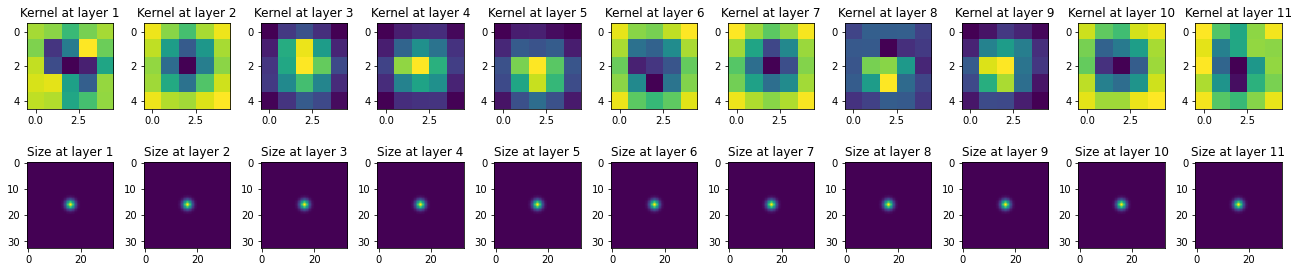

In [7]:
gaussian = lambda x, mu, sigma: 1./(sigma * np.sqrt(2 * np.pi)) * np.exp( - (x - mu)**2 / (2 * sigma**2))
x = np.linspace(-1, 1, 33)

figsize = (18, 4)
fig, axs = plt.subplots(nrows=2, ncols=11,figsize=figsize)

counter = 0
for m in network.modules():
    if isinstance(m, cknn.FlexConv):
        axs[0,counter].set_title('Kernel at layer {}'.format(counter + 1))
        axs[0,counter].imshow(m.conv_kernel[0,0].detach().cpu().numpy())
        
        # Plot gaussian mask by outer product of 1D gaussians
        x_mu = m.mask_params[0,0].detach().numpy()
        x_sigma = m.mask_params[0,1].detach().numpy()
        y_mu = m.mask_params[1,0].detach().numpy()
        y_sigma = m.mask_params[1,1].detach().numpy()
        axs[1,counter].set_title('Size at layer {}'.format(counter + 1))
        gauss = np.outer(gaussian(x, x_mu, x_sigma), gaussian(x, y_mu, y_sigma))
        axs[1,counter].imshow(gauss)
        
        counter = counter + 1
        
plt.tight_layout()
plt.show()

As you can see, all filters are quite small at initialization, as the gaussian masks are initialized to have a low variance. If we were to train this FlexNet-5 model on CIFAR-10, we would find that the kernel sizes increase with depth, as in the middle row of Fig. 6 from the paper, reproduced here:

![](kernel_sizes_flexnet.png)

Finally, we look at the number of parameters and the dimension of the filters of the network:

In [8]:
# ------------------------------
# Parameter counter
def num_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
# -----------------------------

print('Convolutional Kernel Sizes:')
for m in network.modules():
    if isinstance(m, cknn.FlexConv):
        print(m.conv_kernel.shape)
    elif isinstance(m, torch.nn.Linear):
        print(m.weight.shape)
         
print('Number of parameters: {}'.format(num_params(network)))

Convolutional Kernel Sizes:
torch.Size([22, 3, 5, 5])
torch.Size([22, 22, 5, 5])
torch.Size([22, 22, 5, 5])
torch.Size([33, 22, 5, 5])
torch.Size([33, 33, 5, 5])
torch.Size([33, 33, 5, 5])
torch.Size([33, 33, 5, 5])
torch.Size([44, 33, 5, 5])
torch.Size([44, 44, 5, 5])
torch.Size([44, 44, 5, 5])
torch.Size([44, 44, 5, 5])
Number of parameters: 454046


# Aliasing regularization

To use FlexNets across different resolutions one needs to train with an anti-aliasing regularization term. The module `antialiasing.py` provides the necessary methods. 

## Using pre-defined method for whole network

The method `regularize_gabornet()` applies regularization to a network with FlexConv modules that all have the same horizon. Internally, it supports a couple different settings for applying the regularization over multiple modules and filters, but using the default settings, which we also used in our experiments, should be sufficient. Specifically, the default setting uses the following algorithm, in parallel  for all FlexConv modules in the network:

1. We compute the frequency response $f^+_{\textrm{MAGNet},l}$ of each layer $l \in L$ of the MAGNet, as well as the frequency response of the FlexConv gaussian mask $f^+_{w_\textrm{gauss}}$ for the whole MAGNet.
2. We distribute $f^+_{w_\textrm{gauss}}$ uniformly over all MAGNet layer frequency responses $f^+_{\textrm{MAGNet},l}$:

$\hat{f}^+_{\textrm{MAGNet},l} = f^+_{\textrm{MAGNet},l} + \frac{f^+_{w_\textrm{gauss}}}{L}$

3. We then regularize each MAGNet layer $\hat{f}^+_{\textrm{MAGNet},l}$ against a uniform part of the Nyquist frequency:

$\mathcal{L}_{\mathrm{HF}} = \sum_l^L ||\max\{\hat{f}^+_{\textrm{MAGNet},l}, \frac{1}{L} f_{\mathrm{Nyq}}(k)\} - \frac{1}{L} f_{\mathrm{Nyq}}(k)||^2 $

This implementation of the regularization ensures that all layers of the MAGNet get an independent regularization signal, instead of making the regularization term of individual layers dependent on each other. Notably, it is slightly different from the "naive" implementation of the regularization in Eq. 25 of our paper.

This is the init signature of `regularize_gabornet()`:

```
regularize_gabornet()

:param model: Model definition to be regularized (torch.nn.Module).
:param horizon: Integer horizon used in the FlexConvs of this network.
:param factor: Lambda weight for applying the regularization term to the loss.
:param target="gabor": Which parts of the FlexConv to regularize. Use "gabor+mask" for including the gaussian mask, and "gabor" for excluding it.
:param fn="l2_relu": Function applied over the excess frequency content to regularize it.
:param method="together": How to collect the different excess frequencies for regularization.
:param gauss_stddevs=1.0: Standard deviations used to compute the effect of the gaussian term in the Gabor filters.
```

In [9]:
from antialiasing import regularize_gabornet


regularization_term = regularize_gabornet(network, config.conv.horizon, 0.1, target="gabor+mask")
print(regularization_term)

tensor(433.4299, grad_fn=<MulBackward0>)


## Manually

`regularize_gabornet()` is a custom piece of code, that supports many more features than reported in our paper. Here, we show the minimal code for reproducing the proposed regularization method, using the "together" strategy. We use the helper methods in `antialiasing.py`.

First, we use the method `gabor_layer_frequencies()` to get the maximum frequency response for a single FlexConv module:

In [23]:
from antialiasing import gabor_layer_frequencies, nyquist_frequency, l2_relu


module = network.cconv1
magnet_layer_frequencies, mask_frequency = gabor_layer_frequencies(module, "gabor+mask", "together", gauss_stddevs=1.0)

print("Frequencies for each layer of the MAGNet:")
print(magnet_layer_frequencies)

print("Frequency of the FlexConv gaussian mask:")
print(mask_frequency)

Frequencies for each layer of the MAGNet:
tensor([20.0273, 10.9657,  8.2731,  3.4877], grad_fn=<CopySlices>)
Frequency of the FlexConv gaussian mask:
tensor(2.1221, grad_fn=<DivBackward0>)


Then, we distribute the mask frequency over the MAGNet layer frequencies.

In [24]:
# Distribute mask frequency equally over all magnet layer frequencies
n_filters = magnet_layer_frequencies.shape[0]
mask_freqs = mask_frequency.unsqueeze(0).repeat([n_filters]) / torch.tensor(
    n_filters, dtype=torch.float32
)
flexconv_freqs = magnet_layer_frequencies + mask_freqs

print("Frequencies for each layer of the MAGNet, after including uniformly distributed mask frequency:")
print(flexconv_freqs)

Frequencies for each layer of the MAGNet, after including uniformly distributed mask frequency:
tensor([20.5578, 11.4962,  8.8036,  4.0182], grad_fn=<AddBackward0>)


Now, we compute the Nyquist frequency for the kernel size ("horizon") we are training with. We divide by the amount of layers, as per the "together" regularization strategy:

In [ ]:
# Compute Nyquist frequency
nyquist_freq = nyquist_frequency(config.conv.horizon)
print("\nNyquist frequency:")
print(nyquist_freq)
# We uniformly spread the Nyquist frequency over all layers of the MAGNet,
# following the "together" method
print("\nNyquist frequency, per layer:")
print(nyquist_freq / n_filters)

Finally, we compute the regularization term by taking the difference between the MAGNet frequencies and the Nyquist frequencies, and compute the L2 norm:

In [ ]:
# Compute regularization term
frequencies_to_reg = flexconv_freqs - (nyquist_freq / n_filters)
print("\nAmount of frequency to remove, per layer:")
print(frequencies_to_reg)
print("\nRegularization term = L2(freqs - nyquist):")
print(l2_relu(flexconv_freqs, nyquist_freq / n_filters))